<a href="https://colab.research.google.com/github/Natasha617/Diploma/blob/main/Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **"Разработка рекомендательной сиситемы для создания программ дополнительного образования школьников"**

Для построения модели нам нужны данные. И очень часто эти данные содержатся во внешних файлах. Если внешние файлы хранятся на локальном компьютере, то нам нужно подгрузить их в так называемое «Сессионное хранилище». Слово «сессионное» указывает на то, что данные хранятся временно и после завершения очередной сессии стираются.

Сперва из библиотеки goole.colab импортируем класс drive. Далее просматриваем содержимое папки /content/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Указываем путь к нашему файлу и меняем его название.

In [ ]:
!cp "/content/drive/MyDrive/все предметы/4 курс/диплом/data_ne.xlsx" /content/data.xlsx

cp: cannot stat '/content/drive/MyDrive/магистратура/NLP/spam_or_not_spam.csv': No such file or directory


Устанавливаеме и импортируем все нужные библиотеки.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

Читаем файл с данными с помощью функции read_excel

In [ ]:
data = pd.read_excel("data.xlsx",index_col=0).drop(columns=['Unnamed: 0'])

# **Предварительная обработка данных**

Меняем названия колонок.

In [ ]:
new_names=["gender","type_fast","can_save_file","can_make_doc","know_comb","files_on_flash","can_use_internet","like_draw","wanna_make_game","age","made_scratch","like_cartoons","can_make_animation","wanna_cartoon_character","wanna_make_cartoon","made_cartoon", "voice_cartoon", "wanna_edit_photo", "learn_prog_minecraft","wanna_3D_world", "can_prog_turtle","can_scretch","self_prog","wanna_3Dobjects","made_3d_2d_game","wanna_web_design","like_gesign","like_puzzles","wanna_logics_ex","wanna_app","scale_logics_ex","made_site","learn_prog_minecraft","scale_roblox","wanna_3Dobjects","programmed_roblox","know_unity","scale_draw_design","wanna_web_desig","scale_web_design","learn_web_logic","scale_web_logic","wanna_make_site","like_puzzles", "wanna_logics_ex","wanna_AI","wanna_bot", "know_Python","know_С++","know_С#","know_JS","wanna_3Dobjects","wanna_animation","wanna_app","wanna_virus","know_security","wanna_security_threats","wanna_code","wanna_mobile_game","know_unity","like_design","rec1","rec2"]
data.columns=new_names

В связи с тем, что некоторые одинаковые вопросы из опросника выгрузились как разные необходимо их объединить в один столбец

In [ ]:
data['learn_prog_minecraft']

,learn_prog_minecraft,learn_prog_minecraft
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,да,NaN
4,NaN,да
...,...,...
211,NaN,NaN
212,NaN,NaN
213,NaN,NaN
214,NaN,NaN


In [ ]:
for column_name in data.columns:
  if isinstance(data[column_name], pd.core.frame.DataFrame):
    doubled=data[column_name].fillna("").sum(axis=1)
    data = data.drop(columns=[column_name])
    data[column_name] = doubled
data['learn_prog_minecraft']

0        
1        
2        
3      да
4      да
       ..
211      
212      
213      
214      
215      
Name: learn_prog_minecraft, Length: 216, dtype: object

Все вопросы были двух типов: либо "да -нет", либо шкалы.

Cоздается список(non_bool_features), состоящий из названий колонок, которые содержат категориальные значения. Из него, путём вычитания множеств, получим множество имен колонок(bool_features), содержащее булевые значения.
Таким образом мы разделим данные на две части. Первая - часть с дублированными колонками. Вторая - часть колонок в единственном экземпляре.

In [ ]:
non_bool_features = ['age', 'gender','scale_logics_ex', 'scale_roblox', 'scale_draw_design', 'scale_web_design','scale_web_logic']
answers=['rec1','rec2']
bool_features=set(new_names)-set(non_bool_features)-set(answers)

Пробегаемся по колонкам с булевыми значениями(да, нет) и меняем их на 1 и 0. А любые другие значения на -1.

In [ ]:
for feature in bool_features:
  data[feature] = data[feature].map(defaultdict(lambda:0,{"да":1, "нет":-1}))

In [ ]:
data["gender"].value_counts()

мужской    121
женский     95
Name: gender, dtype: int64

Так как уникальных значений в столбце 'gender' всего два, его тоже можно сделать булевым

In [ ]:
data["gender"]= data['gender'].map(defaultdict(lambda:0,{"женский":1, "мужской":-1}))
data=data.rename(columns = {"gender":"is_female"})

Меняем все оставшиеся значения Nan на 0

In [ ]:
data=data.fillna(0)

для того, чтобы модель могла численно интерпретировать значения

In [ ]:
data['scale_draw_design']

0      0.0
1      0.0
2      0.0
3      0.0
4      4.0
      ... 
211    0.0
212    0.0
213    0.0
214    0.0
215    0.0
Name: scale_draw_design, Length: 216, dtype: float64

Усредняется возраст

In [ ]:
data['age']=data['age'].map({'6-7': 6.5, '8-9': 8.5, '10-12': 11, '13+': 14})

# **Исследовательский анализ данных(EDA)**

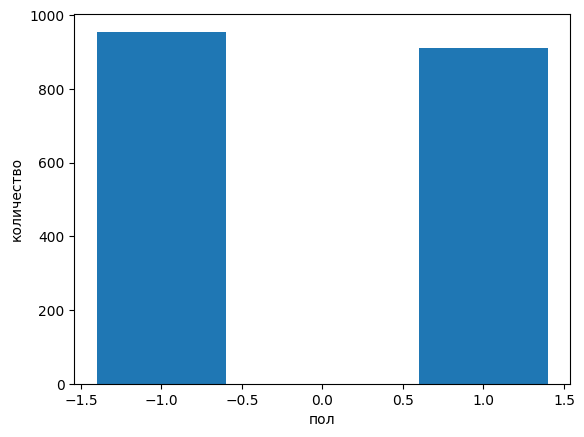

In [ ]:
import matplotlib.pyplot as plt
is_female_value = data['is_female'].value_counts()
plt.bar(is_female_value.index,is_female_value.values)
plt.xlabel('пол')
plt.ylabel('количество')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
value = data['age'].value_counts()
plt.bar(value.index,value.values)
plt.xlabel('возраст')
plt.ylabel('количество')
plt.show()

In [ ]:
data['age']. corr(data['know_unity'])

0.06758459900487356

In [ ]:
data[["rec1","age"]].value_counts()

rec1                      age 
web- разработка           14.0    182
Python "Чат-бот"          14.0    128
Компьютерная грамотность  8.5     127
Кибербезопасность         14.0    125
Roblox                    11.0    111
Godot                     14.0     98
Создание приложений       11.0     97
Python "Нейросети"        14.0     96
Unity                     11.0     94
Компьютерная грамотность  14.0     86
                          11.0     83
web- разработка           11.0     80
Python основы             11.0     73
web-дизайн                14.0     69
ScratchJr                 6.5      68
Minecraft                 11.0     67
изуение PHP               14.0     66
Python основы             14.0     63
Scratch 3                 8.5      40
CoSpaces                  8.5      40
codu                      6.5      39
Minecraft                 8.5      34
dtype: int64

In [ ]:

data_male = data[data['is_female'] == -1] # отбираем только строки с мужчинами
male_recommendations = data_male['rec1'].value_counts()
data_female = data[data['is_female'] == 1] # отбираем только строки с женщинами
female_recommendations = data_female['rec1'].value_counts()
print(male_recommendations,female_recommendations )

web- разработка             137
Компьютерная грамотность    136
Python основы                79
Кибербезопасность            64
Python "Чат-бот"             63
Roblox                       54
Создание приложений          54
Minecraft                    53
Godot                        53
Unity                        51
Python "Нейросети"           40
web-дизайн                   37
изуение PHP                  35
ScratchJr                    34
Scratch 3                    23
CoSpaces                     22
codu                         20
Name: rec1, dtype: int64 Компьютерная грамотность    160
web- разработка             125
Python "Чат-бот"             65
Кибербезопасность            61
Python основы                57
Roblox                       57
Python "Нейросети"           56
Minecraft                    48
Godot                        45
Создание приложений          43
Unity                        43
ScratchJr                    34
web-дизайн                   32
изуение PHP    

In [ ]:
data[["rec2","age"]].value_counts()

rec2                 age 
Python "Нейросети"   14.0    159
Python "Чат-бот"     14.0    159
Python основы        11.0    138
Создание приложений  11.0    137
Изучение JavaScript  14.0    100
Векторная графика    11.0     97
Scratch 3            8.5      75
Gif-анимация         6.5      73
CoSpaces             8.5      71
Figma Basic          14.0     70
Python в Minecraft   11.0     69
web- разработка      14.0     67
Кибербезопасность    14.0     64
Unity                11.0     62
web- разработка      11.0     62
Основы С++           14.0     62
Minecraft            8.5      52
Roblox               8.5      43
                     11.0     40
Python основы        14.0     38
Игровой JavaScript   14.0     35
codu                 6.5      34
Создание приложений  14.0     33
web-дизайн           14.0     33
Игры на Python       14.0     31
Векторная графика    14.0     31
Unity                14.0     31
dtype: int64

# **Обучение модели и оценка качества**

Импорт нужных библиотек

In [ ]:
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

Далее y1 и y2 - столбцы с рекомендациями

X - остальные данные

In [ ]:
y1 = data['rec1']
y2 = data['rec2']

In [ ]:
X = data.drop(columns = ['rec1','rec2'])

Разбиение на тестовую и обучающую выборку:

In [ ]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, random_state= 0, test_size= 0.3 )


Подбор параметров

In [ ]:
clf = tree.DecisionTreeClassifier()
parametrs = { 'criterion': ['gini', 'entropy','log_loss'],
              'splitter': ['best', 'random'],
              'max_depth': [10,11],
              'min_samples_split': [2,3],
              'random_state': [40,50]
            }
grid_tree1 = GridSearchCV(clf, parametrs, cv=10,scoring="f1_weighted")
grid_tree2 = GridSearchCV(clf, parametrs, cv=10,scoring="f1_weighted")
grid_tree1.fit(X, y1)
grid_tree2.fit(X, y2)
print(f'Лучшие параметры для дерева решений(rec1):{grid_tree1.best_params_}')
print(f'Лучшие параметры для дерева решений(rec2):{grid_tree2.best_params_}')
print(f'Лучший результат предсказания(rec1):{grid_tree1.best_score_}')
print(f'Лучший результат предсказания(rec2):{grid_tree2.best_score_}')

Лучшие параметры для дерева решений(rec1):{'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 2, 'random_state': 50, 'splitter': 'random'}
Лучшие параметры для дерева решений(rec2):{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 3, 'random_state': 40, 'splitter': 'best'}
Лучший результат предсказания(rec1):0.9436489586339704
Лучший результат предсказания(rec2):0.9310559667194145


In [ ]:
plt.figure(dpi = 600)
tree.plot_tree(clf)
plt.savefig('tree.png',format='png',bbox_inches = "tight")

In [ ]:
clf = tree.DecisionTreeClassifier(**grid_tree1.best_params_) #создание модели с лучшими параметрами
clf.fit(X_train,y1_train)

DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=50,
                       splitter='random')

In [ ]:
f1_score(y1_test, clf.predict(X_test),average='weighted') # оценка качества

0.959348703837118

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X, y1)

array([0.87967914, 0.86595174, 0.90884718, 0.96782842, 0.90348525])

In [ ]:
clf.fit(X,y1)

DecisionTreeClassifier(random_state=50)

In [ ]:
len(data[data['rec1']=='Roblox'].drop(columns=['rec1','rec2']).value_counts())

In [ ]:
len(data[['rec1','rec2']].value_counts())

55

In [ ]:
clf1 = LogisticRegression() # то же самаое для логистической регрессии
parametrs = { 'penalty': ['l1', 'l2', 'elasticnet', None],
              'random_state': [40,50],
              'tol': [1,2,3]
            }
grid_log1 = GridSearchCV(clf1, parametrs, cv=10,scoring="f1_weighted")
grid_log2 = GridSearchCV(clf1, parametrs, cv=10,scoring="f1_weighted")
grid_log1.fit(X, y1)
grid_log2.fit(X,y2)
print(f'Лучшие параметры для логистической регрессии(rec1):{grid_log1.best_params_}')
print(f'Лучшие параметры для логистической регрессии(rec2):{grid_log2.best_params_}')
print(f'Лучший результат предсказания(rec1):{grid_log1.best_score_}')
print(f'Лучший результат предсказания(rec2):{grid_log2.best_score_}')

In [ ]:
clf1 = LogisticRegression(**grid_log1.best_params_)
clf1 = clf1.fit(X_train, y1_train)

f1_score(y1_test, clf1.predict(X_test),average='weighted')

0.9390075785555504

In [ ]:
clf2 = svm.SVC() # метод опорных векторов
parametrs = { 'C': [0.1, 0.3, 0.5, 0.7, 1, 1.5, 2],
             'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
             'tol':[1,2,3]
            }
grid_svm1 = GridSearchCV(clf2, parametrs, cv=10,scoring="f1_weighted")
grid_svm2 = GridSearchCV(clf2, parametrs, cv=10,scoring="f1_weighted")
grid_svm1.fit(X, y1)
grid_svm2.fit(X, y2)
print(f'Лучшие параметры для SVM(rec1):{grid_svm1.best_params_}')
print(f'Лучшие параметры для SVM(rec2):{grid_svm2.best_params_}')
print(f'Лучший результат предсказания(rec1):{grid_svm1.best_score_}')
print(f'Лучший результат предсказания(rec2):{grid_svm2.best_score_}')


Лучшие параметры для SVM(rec1):{'C': 0.3, 'kernel': 'linear', 'tol': 1}
Лучшие параметры для SVM(rec2):{'C': 0.5, 'kernel': 'linear', 'tol': 1}
Лучший результат предсказания(rec1):0.952977645216017
Лучший результат предсказания(rec2):0.9326998921727535


In [ ]:
clf2 = svm.SVC(**grid_svm1.best_params_)
clf2 = clf2.fit(X_train, y1_train)


f1_score(y1_test, clf2.predict(X_test),average='weighted')

0.9629454805780698

In [ ]:
clf2.fit(X)

In [ ]:
import joblib # сохранение
joblib.dump(clf2,"SVC.pkl")

['SVC.pkl']

In [ ]:
clf3=RandomForestClassifier() # Случайный лес
parametrs = { 'criterion': ['gini', 'entropy','log_loss'],
              'max_depth': [10,11],
              'min_samples_split': [2,3]
            }
grid_forest1 = GridSearchCV(clf3, parametrs, cv=10,scoring="f1_weighted")
grid_forest2 = GridSearchCV(clf3, parametrs, cv=10,scoring="f1_weighted")
grid_forest1.fit(X, y1)
grid_forest2.fit(X, y2)
print(f'Лучшие параметры для RandomForestClassifier(rec1):{grid_forest1.best_params_}')
print(f'Лучшие параметры для RandomForestClassifier(rec2):{grid_forest2.best_params_}')
print(f'Лучший результат предсказания(rec1):{grid_forest1.best_score_}')
print(f'Лучший результат предсказания(rec2):{grid_forest2.best_score_}')

Лучшие параметры для RandomForestClassifier(rec1):{'criterion': 'log_loss', 'max_depth': 11, 'min_samples_split': 3}
Лучшие параметры для RandomForestClassifier(rec2):{'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 2}
Лучший результат предсказания(rec1):0.9826746365027601
Лучший результат предсказания(rec2):0.9699963696323234


In [ ]:
clf_forest1 = RandomForestClassifier(**grid_forest1.best_params_)
clf_forest2 = RandomForestClassifier(**grid_forest2.best_params_)
clf_forest1 = clf_forest1.fit(X,y1)
clf_forest2 = clf_forest2.fit(X,y2)

0.9875751108103324

In [ ]:
import joblib  # Сохранение лучших моделей
joblib.dump(clf_forest1,"forest1.pkl")
joblib.dump(clf_forest2,"forest2.pkl")

['forest2.pkl']

# **Аугментация данных**

In [ ]:
test = X.loc[2]

In [ ]:
len(test)

54

In [ ]:
import json

In [ ]:
json.dumps({"data": [test.tolist()]})

'{"data": [[1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 8.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, -1.0, 0.0, -1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0]]}'

In [ ]:
clf3.predict(X)

array(['Minecraft', 'Minecraft', 'Minecraft', ..., 'Figma Basic',
       'Figma Basic', 'Figma Basic'], dtype=object)

In [ ]:
s = y2 == clf2.predict(X)

In [ ]:
~s

0      True
1      True
2      True
3      True
4      True
       ... 
211    True
212    True
213    True
214    True
215    True
Name: rec2, Length: 216, dtype: bool

In [ ]:
data.age==14.0

0       True
1       True
2       True
3      False
4      False
       ...  
211     True
212     True
213     True
214     True
215     True
Name: age, Length: 216, dtype: bool

In [ ]:
data[~s]

,is_female,type_fast,can_save_file,can_make_doc,know_comb,files_on_flash,can_use_internet,like_draw,wanna_make_game,age,...,wanna_mobile_game,like_design,rec1,rec2,learn_prog_minecraft,wanna_3Dobjects,like_puzzles,wanna_logics_ex,wanna_app,know_unity
0,1,1,1,1,1,1,1,1,-1,14.0,...,-1,1,"Python ""Нейросети""","Python ""Чат-бот""",0,-1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,14.0,...,-1,1,web- разработка,"Python ""Чат-бот""",0,1,1,-1,1,1
2,-1,1,1,1,1,1,1,1,1,14.0,...,-1,1,web- разработка,Python основы,0,-1,1,1,1,1
3,1,-1,1,1,1,1,1,1,1,8.5,...,0,0,CoSpaces,Roblox,1,1,0,0,0,0
4,-1,-1,1,1,1,1,1,-1,1,11.0,...,0,0,Minecraft,Python в Minecraft,1,1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,1,1,1,1,1,1,1,1,-1,14.0,...,-1,1,web-дизайн,Figma Basic,0,-1,1,-1,-1,1
212,-1,-1,1,1,1,1,1,1,-1,14.0,...,-1,1,web-дизайн,Figma Basic,0,-1,-1,-1,-1,-1
213,1,1,1,1,1,-1,1,1,-1,14.0,...,-1,1,web-дизайн,Figma Basic,0,-1,1,-1,-1,1
214,-1,1,1,1,1,1,1,1,-1,14.0,...,-1,1,web-дизайн,Figma Basic,0,-1,-1,-1,-1,-1


In [ ]:
clf2.predict(X)[~s]

array(['Python "Нейросети"', 'web- разработка', 'web- разработка',
       'CoSpaces', 'Minecraft', 'Компьютерная грамотность',
       'web- разработка', 'Python "Чат-бот"', 'web- разработка',
       'web- разработка', 'web- разработка', 'Minecraft', 'Roblox',
       'Компьютерная грамотность', 'Компьютерная грамотность',
       'Компьютерная грамотность', 'Unity', 'Unity', 'web- разработка',
       'web- разработка', 'ScratchJr', 'codu', 'codu', 'ScratchJr',
       'ScratchJr', 'Scratch 3', 'Python "Нейросети"', 'Minecraft',
       'ScratchJr', 'Python основы', 'Создание приложений', 'Roblox',
       'Создание приложений', 'web- разработка', 'Python "Нейросети"',
       'Godot', 'Roblox', 'web- разработка', 'Python основы', 'ScratchJr',
       'web- разработка', 'Python основы', 'Компьютерная грамотность',
       'Компьютерная грамотность', 'web- разработка', 'Roblox',
       'Scratch 3', 'ScratchJr', 'web- разработка', 'Minecraft',
       'web- разработка', 'ScratchJr', 'Компьютерная 

In [ ]:
clf.feature_names_in_

array(['is_female', 'type_fast', 'can_save_file', 'can_make_doc',
       'know_comb', 'files_on_flash', 'can_use_internet', 'like_draw',
       'wanna_make_game', 'age', 'made_scratch', 'like_cartoons',
       'can_make_animation', 'wanna_cartoon_character',
       'wanna_make_cartoon', 'made_cartoon', 'voice_cartoon',
       'wanna_edit_photo', 'wanna_3D_world', 'can_prog_turtle',
       'can_scretch', 'self_prog', 'made_3d_2d_game', 'wanna_web_design',
       'like_gesign', 'scale_logics_ex', 'made_site', 'scale_roblox',
       'programmed_roblox', 'scale_draw_design', 'wanna_web_desig',
       'scale_web_design', 'learn_web_logic', 'scale_web_logic',
       'wanna_make_site', 'wanna_AI', 'wanna_bot', 'know_Python',
       'know_С++', 'know_С#', 'know_JS', 'wanna_animation', 'wanna_virus',
       'know_security', 'wanna_security_threats', 'wanna_code',
       'wanna_mobile_game', 'like_design', 'learn_prog_minecraft',
       'wanna_3Dobjects', 'like_puzzles', 'wanna_logics_ex', 'wann

In [ ]:
d={}
for column in data.columns:
  d[column]=np.unique(data[column]).tolist()


In [ ]:
import random
random.choice(d['can_make_animation'])


0

In [ ]:
data[["rec1", "rec2"]].value_counts().reset_index()['rec1']

0     Компьютерная грамотность
1     Компьютерная грамотность
2                       Roblox
3     Компьютерная грамотность
4                     CoSpaces
5                    Scratch 3
6                         codu
7                       Roblox
8                Python основы
9                    Minecraft
10             web- разработка
11                       Godot
12                 изуение PHP
13                  web-дизайн
14               Python основы
15                   Minecraft
16                   ScratchJr
17             web- разработка
18          Python "Нейросети"
19                  web-дизайн
20         Создание приложений
21                   ScratchJr
22             web- разработка
23             web- разработка
24    Компьютерная грамотность
25    Компьютерная грамотность
26            Python "Чат-бот"
27            Python "Чат-бот"
28                       Unity
29                       Godot
30         Создание приложений
31               Python основы
32      

In [ ]:
for index, row in data[["rec1", "rec2"]].value_counts().reset_index().iterrows():

  print("\'" + row['rec1'] + "\',\'" + row['rec2'] + "\'")

'Компьютерная грамотность','Minecraft'
'Компьютерная грамотность','Roblox'
'Roblox','Python основы'
'Компьютерная грамотность','Scratch 3'
'CoSpaces','Roblox'
'Scratch 3','CoSpaces'
'codu','Gif-анимация'
'Roblox','Создание приложений'
'Python основы','Python в Minecraft'
'Minecraft','Python основы'
'web- разработка','Изучение JavaScript'
'Godot','Игровой JavaScript'
'изуение PHP','Figma Basic'
'web-дизайн','Figma Basic'
'Python основы','Создание приложений'
'Minecraft','Scratch 3'
'ScratchJr','Gif-анимация'
'web- разработка','Python основы'
'Python "Нейросети"','Python "Чат-бот"'
'web-дизайн','web- разработка'
'Создание приложений','Векторная графика'
'ScratchJr','codu'
'web- разработка','Python "Нейросети"'
'web- разработка','web-дизайн'
'Компьютерная грамотность','web- разработка'
'Компьютерная грамотность','Кибербезопасность'
'Python "Чат-бот"','Создание приложений'
'Python "Чат-бот"','Изучение JavaScript'
'Unity','Создание приложений'
'Godot','Python "Нейросети"'
'Создание приложен

In [ ]:
allowed=['is_female', 'wanna_animation','like_draw',
        'know_С++', 'know_С#', 'know_Python',
       'like_design',
        'like_puzzles',
       'wanna_logics_ex', 'know_unity']

In [ ]:
def oversample(df,targets,n_sample,allowed_columns):
    samples=df[(df['rec1']==targets[0])&(df['rec2']==targets[1])].sample(n_sample,replace=True)
    for allowed_column in allowed_columns:
      samples[allowed_column]=np.random.choice(d[allowed_column],n_sample)
    samples.to_excel(f"/content/drive/MyDrive/все предметы/4 курс/диплом/df/{targets[0]+targets[1]}.xlsx")
    return samples


In [ ]:
base_path="/content/drive/MyDrive/все предметы/4 курс/диплом/df/"

In [ ]:
import os
dfs=[]
for element in os.listdir(base_path):
  dfs.append(pd.read_excel(base_path+element))


In [ ]:
dfs.append(data)

In [ ]:

new_data=pd.concat(dfs).reset_index().drop(columns=['index'])
new_data.to_excel('/content/drive/MyDrive/все предметы/4 курс/диплом/data_ne.xlsx')

In [ ]:
oversample(data,('изуение PHP','Кибербезопасность'),30,allowed)

,is_female,type_fast,can_save_file,can_make_doc,know_comb,files_on_flash,can_use_internet,like_draw,wanna_make_game,age,...,wanna_mobile_game,like_design,rec1,rec2,learn_prog_minecraft,wanna_3Dobjects,like_puzzles,wanna_logics_ex,wanna_app,know_unity
56,-1,1,1,1,1,1,1,-1,1,14.0,...,1,1,изуение PHP,Кибербезопасность,0,1,1,1,1,0
56,-1,1,1,1,1,1,1,-1,1,14.0,...,1,1,изуение PHP,Кибербезопасность,0,1,-1,0,1,-1
56,1,1,1,1,1,1,1,1,1,14.0,...,1,0,изуение PHP,Кибербезопасность,0,1,1,0,1,0
56,1,1,1,1,1,1,1,1,1,14.0,...,1,-1,изуение PHP,Кибербезопасность,0,1,1,-1,1,1
56,-1,1,1,1,1,1,1,-1,1,14.0,...,1,0,изуение PHP,Кибербезопасность,0,1,-1,1,1,1
56,1,1,1,1,1,1,1,-1,1,14.0,...,1,0,изуение PHP,Кибербезопасность,0,1,0,1,1,-1
56,-1,1,1,1,1,1,1,1,1,14.0,...,1,-1,изуение PHP,Кибербезопасность,0,1,-1,1,1,-1
56,1,1,1,1,1,1,1,-1,1,14.0,...,1,1,изуение PHP,Кибербезопасность,0,1,1,0,1,1
56,-1,1,1,1,1,1,1,-1,1,14.0,...,1,1,изуение PHP,Кибербезопасность,0,1,-1,-1,1,0
56,-1,1,1,1,1,1,1,1,1,14.0,...,1,0,изуение PHP,Кибербезопасность,0,1,-1,-1,1,-1
